In [176]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [137]:
bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32)
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32)
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)

In [138]:
E_id = pcaBasis_id[:,:30]
E_exp = pcaBasis_exp[:,:20]
sigma_id = np.sqrt(pcaVariance_id[:30])
sigma_exp = np.sqrt(pcaVariance_exp[:20])

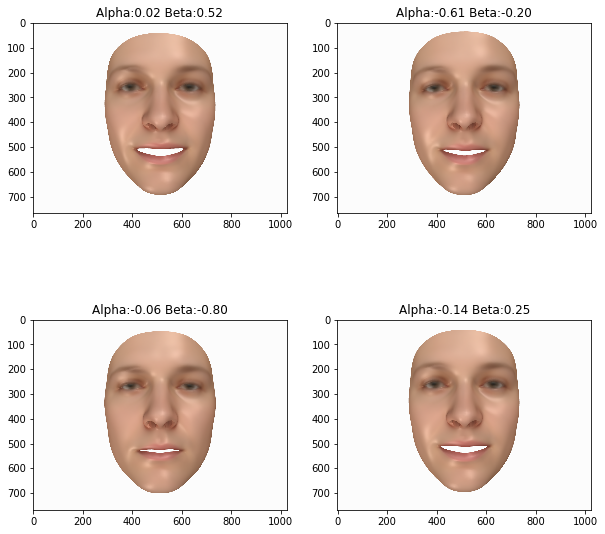

In [139]:
# Generate point clouds using uniform sample
os.makedirs('results/',exist_ok=True)
fig1 = plt.figure(figsize = (10,10))
for i in range(4):
    alpha = np.random.uniform(-1,1)
    beta = np.random.uniform(-1,1)
    G = mu_id + E_id @ sigma_id * alpha + mu_exp + E_exp @ sigma_exp * beta
    G = G.reshape(-1,3)
    mesh = Mesh(G, mean_tex, triangles)
    filepath = 'results/point_cloud_sample{}.png'.format(i+1)
    mesh_to_png(filepath, mesh) 
    image = mpimg.imread(filepath)
    subplot = fig1.add_subplot(2,2,i+1)
    subplot.imshow(image)
    subplot.set_title('Alpha:{:.2f} Beta:{:.2f}'.format(alpha,beta))
plt.show()

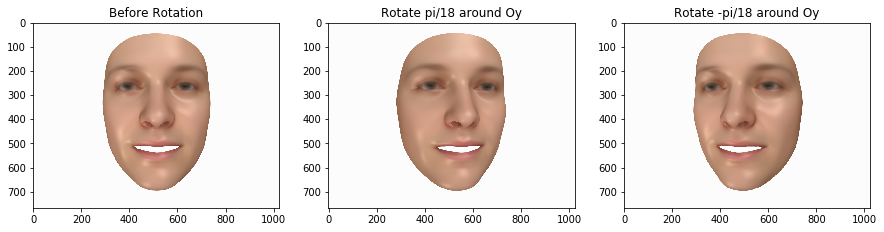

In [157]:
# Rotate around Oy
fig2 = plt.figure(figsize = (15,10))
subplot = fig2.add_subplot(1,3,1)
subplot.imshow(image)
subplot.set_title("Before Rotation")
# Rotate pi/18 around Oy 
theta = np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y1.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,2)
subplot.imshow(image_t)
subplot.set_title("Rotate pi/18 around Oy")
# Rotate -pi/18 around Oy
theta = -np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y2.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,3)
subplot.imshow(image_t)
subplot.set_title("Rotate -pi/18 around Oy")
plt.show()

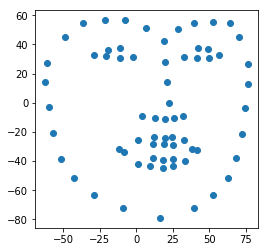

In [170]:
# visualize facial landmark points on the 2D image plane
landmarks=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmarks.append(int(line.split('\n')[0]))
G_landmark = np.ones((4,len(landmarks)))
G_landmark[:3,:]= G[landmarks,:].T
theta = np.pi/18.
T = np.array([[np.cos(theta),0, np.sin(theta),0],
              [0,1,0,0],[-np.sin(theta),0,np.cos(theta),0],
              [0,0,0,1]])
vl,vr,vb,vt = -1,1,-1,1
V = np.array([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t,n,f = -1,1,-1,1,1,100
P = np.array([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t-b),(t+b)/(t-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])
output = V @ P @ T @ G_landmark
plt.scatter(output[0,:],output[1,:])
plt.axes().set_aspect('equal')
plt.show()

In [177]:
test_image = mpimg.imread('test.png')
detect_landmark(test_image)

RuntimeError: Unable to open shape_predictor_68_face_landmarks.dat